In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np

warnings.filterwarnings("ignore")

# Loading the data from csv files

energyB = pd.read_csv('../Assignment 1 /data/HomeB-meter1_2014.csv')
energyC = pd.read_csv('../Assignment 1 /data/HomeC-meter1_2016.csv')
energyF = pd.read_csv('../Assignment 1 /data/HomeF-meter3_2016.csv')

In [2]:
# Date column -> datetime object
energyB['Date & Time']= pd.to_datetime(energyB['Date & Time']) 
energyC['Date & Time']= pd.to_datetime(energyC['Date & Time']) 
energyF['Date & Time']= pd.to_datetime(energyF['Date & Time']) 

In [3]:
start = "11-01-2014"
end = "11-15-2014"

energyB["Date & Time"] = energyB["Date & Time"].dt.floor(freq="30T")
energyB = energyB.groupby("Date & Time").sum().reset_index()

energyB = energyB.loc[energyB["Date & Time"] >= start]
energyB = energyB.loc[energyB["Date & Time"] < end]
energyB.reset_index(drop=True, inplace=True)
energyBdata = energyB['use [kW]']
energyBdata.index = np.arange(1, len(energyBdata) + 1)

In [4]:
start = "11-01-2016"
end = "11-15-2016"

energyC["Date & Time"] = energyC["Date & Time"].dt.floor(freq="30T")
energyC = energyC.groupby("Date & Time").sum().reset_index()

energyC = energyC.loc[energyC["Date & Time"] >= start]
energyC = energyC.loc[energyC["Date & Time"] < end]
energyC.reset_index(drop=True, inplace=True)
energyCdata = energyC['use [kW]']
energyCdata.index = np.arange(1, len(energyCdata) + 1)

In [5]:
start = "11-01-2016"
end = "11-15-2016"

energyF["Date & Time"] = energyF["Date & Time"].dt.floor(freq="30T")
energyF = energyF.groupby("Date & Time").sum().reset_index()

energyF = energyF.loc[energyF["Date & Time"] >= start]
energyF = energyF.loc[energyF["Date & Time"] < end]
energyF.reset_index(drop=True, inplace=True)
energyFdata = energyF['Usage [kW]']
energyFdata.index = np.arange(1, len(energyFdata) + 1)

In [6]:
plt.rcParams["figure.figsize"] = [21, 10] 
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['text.color'] = 'black'

def plot_graph_offline(prov_type, x, trueValues, house):
  plt.figure(figsize=(20, 5))
  plt.title("Actual vs Optimal values for Offline " + prov_type + " provisioning" + " House " + house)
  plt.plot(x, 'b', label="Optimal Values")
  plt.plot(trueValues, 'r', label="True Values")
  plt.legend()
  plt.ylabel("Electricity Units in kW")
  plt.xlabel("Time step t(1 unit = 15 minutes)")

In [7]:
#Store algorithms, optimal values and decision values for objective function
opt_dict_B = {}
opt_dict_C = {}
opt_dict_F = {}
decision_dict_B = {}
decision_dict_C = {}
decision_dict_F = {}
opt_dict = [opt_dict_B, opt_dict_C, opt_dict_F]
decision_dict = [decision_dict_B, decision_dict_C, decision_dict_F]
offline_static = []
houses = ['B', 'C', 'F']
energyData = [energyBdata, energyCdata, energyFdata]

In [8]:
def offline_static_provision(house,df):
  p = 0.4/2 #Half hourly rate
  a = 4/2
  b = 4/2
  y = df.to_list()
  x = cp.Variable(1)

  cost = p*x + a*cp.maximum(0, y - x)
  objective = cp.Minimize(cp.sum(cost) + b*x)
  constraints = [0 <= x]
  problem = cp.Problem(objective, constraints)
  result = problem.solve()
  opt = pd.Series(np.full((672), x.value), index=df.index)
#   opt_dict['Offline Static'] = result
#   decision_dict['Offline Static'] = opt

  print("The optimal value for static provisioning for house ", house ," is ", result)
  print("The optimal x for the same is : ", x.value)
  plot_graph_offline('static', opt, df, house)
  return result, opt

The optimal value for static provisioning for house  B  is  194.84252933729957
The optimal x for the same is :  [0.907565]
The optimal value for static provisioning for house  C  is  7989.918093270889
The optimal x for the same is :  [41.14206667]
The optimal value for static provisioning for house  F  is  19396.101745950808
The optimal x for the same is :  [119.74353333]


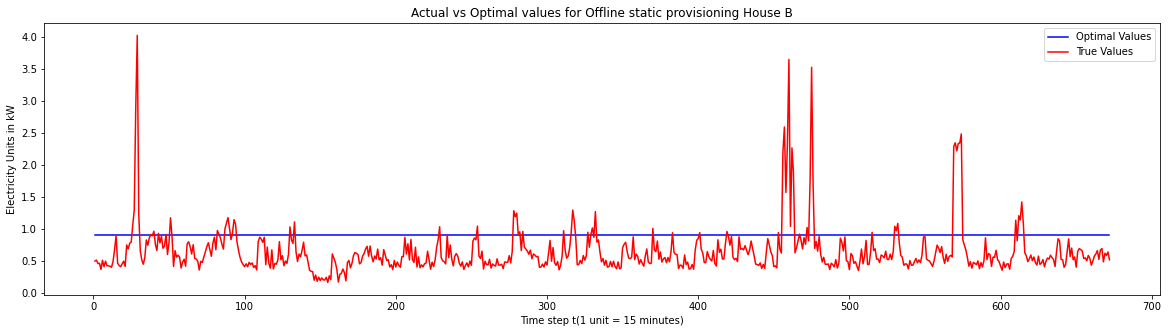

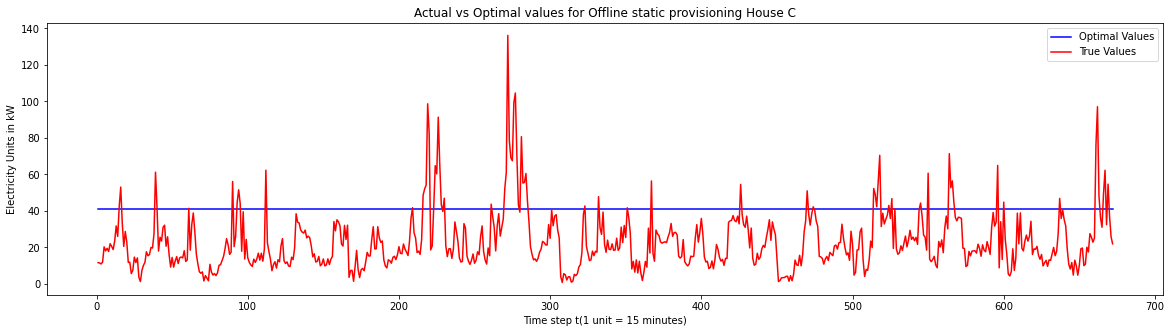

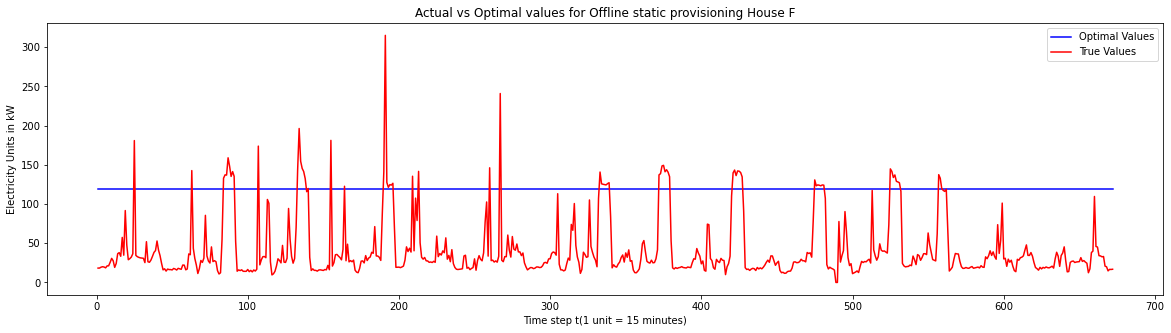

In [9]:
for i in range(3):
    result, opt = offline_static_provision(houses[i] ,energyData[i])
    opt_dict[i]['Offline Static'] = result
    decision_dict[i]['Offline Static'] = opt
    offline_static.append(result)

In [10]:
comparison = pd.DataFrame({
    'House': houses,
    'Cost': offline_static,
})
comparison

,House,Cost
0,B,194.842529
1,C,7989.918093
2,F,19396.101746


### Offline Dynamic Optimisation

In [11]:
def offline_dynamic_provision(house, df):
  p = 0.4/2
  a = 4/2
  b = 4/2
  y = df.to_list()
  x = cp.Variable(672)
  cost = 0

  for i in range(1,672):
      cost += p*x[i] + a*cp.maximum(0, y[i-1] - x[i]) + b*cp.abs(x[i]-x[i-1])
  
  objective = cp.Minimize(cost)
  constraints = [x[0] == 0, x[1:] >= 0]
  problem = cp.Problem(objective, constraints)
  result = problem.solve()
  opt = pd.Series(np.array(x.value), index=df.index)


  print("\nThe optimal value is", result)
  plot_graph_offline('dynamic', opt, df, house)
  return result, opt



The optimal value is 161.34680706547033

The optimal value is 6696.918532777977

The optimal value is 14778.496106597464


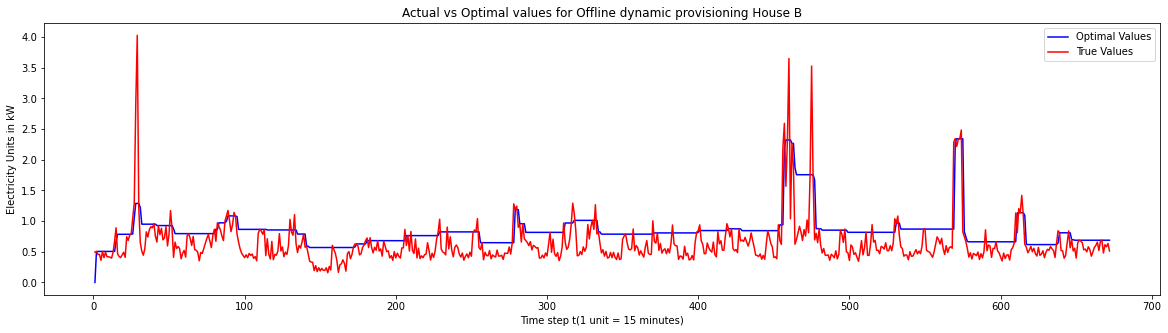

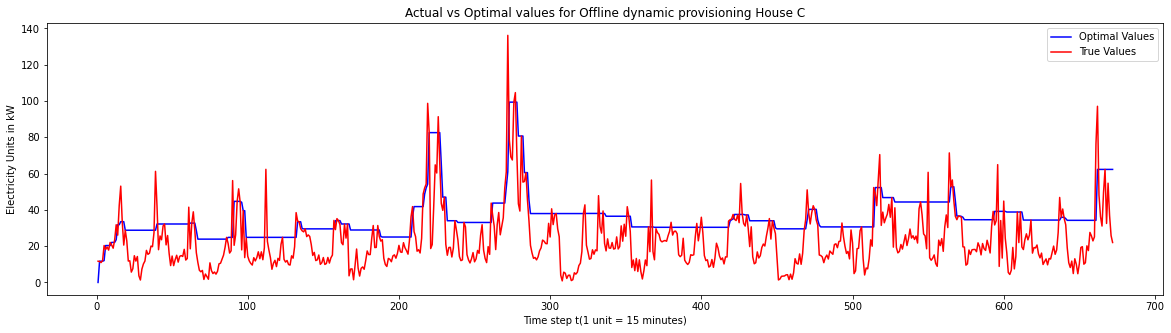

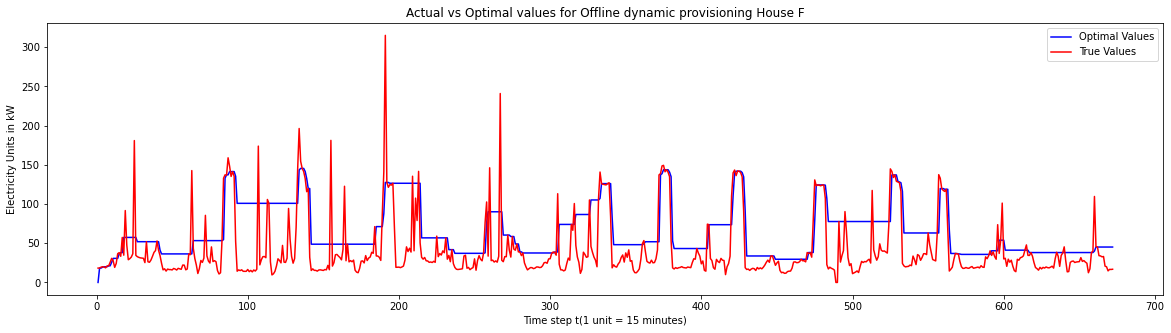

In [12]:
offline_dynamic = []
for i in range(3):
    result, opt = offline_dynamic_provision(houses[i], energyData[i])
    opt_dict[i]['Offline Dynamic'] = result
    decision_dict[i]['Offline Dynamic'] = opt
    offline_dynamic.append(result)


### ONLINE GRADIENT DESCENT

In [13]:
def cost(method, x, y, verbose):
    cost = 0
    p = 0.4/2
    a = 4/2
    b = 4/2
    for i in range(1, len(y) + 1):
        cost += p * x[i] + a * max(0, y[i] - x[i] + b * abs(x[i] - x[i - 1]))
    if (verbose == True):                         
      print("\nThe objective value for " + method + " is", cost)
    return cost

In [14]:
def gradient(x, y, t, p, a, b):
    slope = 0

    if (y[t] > x[t]):
        if (x[t] > x[t - 1]):
            slope = p - a + b;
        else:
            slope = p - a - b;
    else:
        if (x[t] > x[t - 1]):
            slope = p + b;
        else:
            slope = p - b;
    return slope;

In [15]:
def online_gradient_descent(y, steps):
    n = len(y)
    x = [0.0] * (n + 1)
    x[1] = 0
    p = 0.4/2
    a = 4/2
    b = 4/2
    for t in range(1, n):
        x[t + 1] = x[t] - steps * gradient(x, y, t, p, a, b)
    return x

In [16]:
x = online_gradient_descent(energyBdata, steps = 0.1)

In [17]:
cost('Online Gradient Descent', x, energyBdata, True)


The objective value for Online Gradient Descent is 371.0574300160019


371.0574300160019

In [18]:
def plot_ogd(house, steps, costs):
    plt.figure(figsize=(20, 5))
    plt.title("Online Gradient Descent Optimal Cost for House " + house)
    plt.plot(steps, costs, label = "Cost")
    plt.legend()
    plt.ylabel("Cost Value")
    plt.xlabel("Step Size")
    plt.show()

In [19]:
def plot_comparison(house, optimalValues, trueValues):   
    plt.figure(figsize=(20, 5))
    plt.title("Actual vs Optimal | Online Gradient Descent | House " + house)
    plt.plot(optimalValues, 'b', label="Usage Values")
    plt.plot(trueValues, 'r', label="Provision Values")
    plt.legend()
    plt.ylabel("Electricity Units in kWH")
    plt.xlabel("Time step t(1 unit = 15 minutes)")

In [20]:
ogd= []

Optimal cost found at step:  0.022599999999999974

The objective value for Online Gradient Descent at Optimal cost is 215.83683934600026


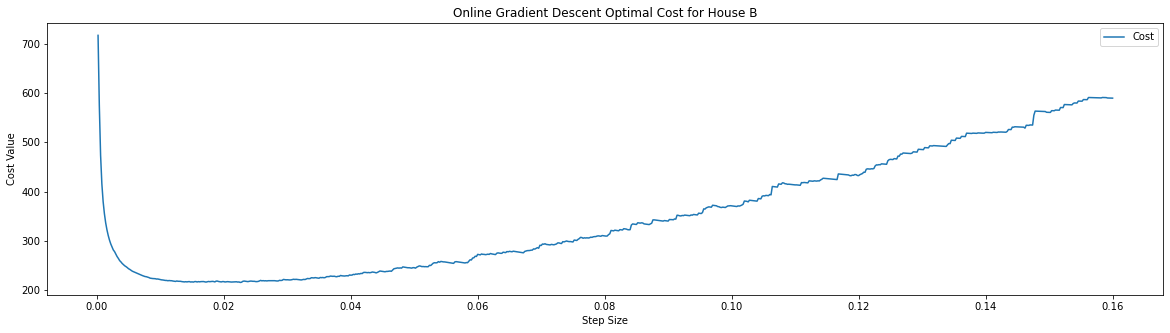

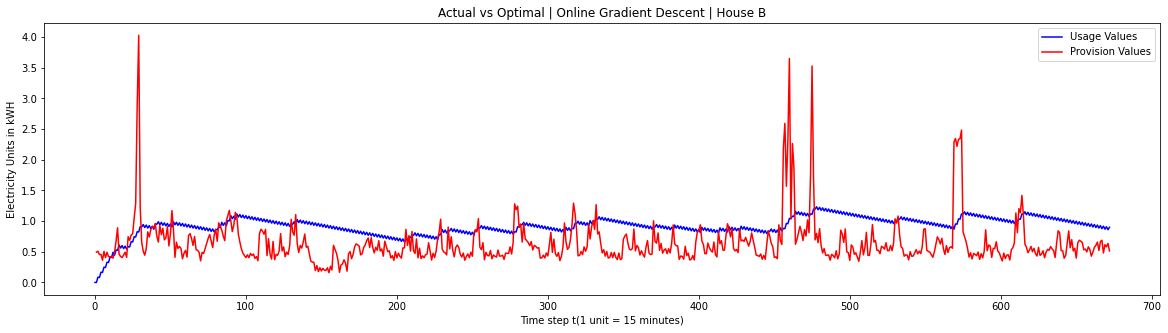

In [21]:
costs = []
steps = []
step = 0
for i in range(800):
    step += 0.0002
    x = online_gradient_descent(energyBdata, steps = step)
    steps.append(step)
    costs.append(cost("Cost", x ,energyBdata, False))

x = online_gradient_descent(energyBdata, steps = steps[costs.index(min(costs))])
print("Optimal cost found at step: ", steps[costs.index(min(costs))])
opt = cost("Online Gradient Descent at Optimal cost", x, energyBdata, True)
opt_dict[0]['OGD'] = opt
decision_dict[0]['OGD'] = x
ogd.append(opt)
plot_ogd("B", steps, costs)
plot_comparison("B", x, energyBdata)


Optimal cost found at step:  0.8520000000000006

The objective value for Online Gradient Descent at Optimal cost is 8717.683653388014


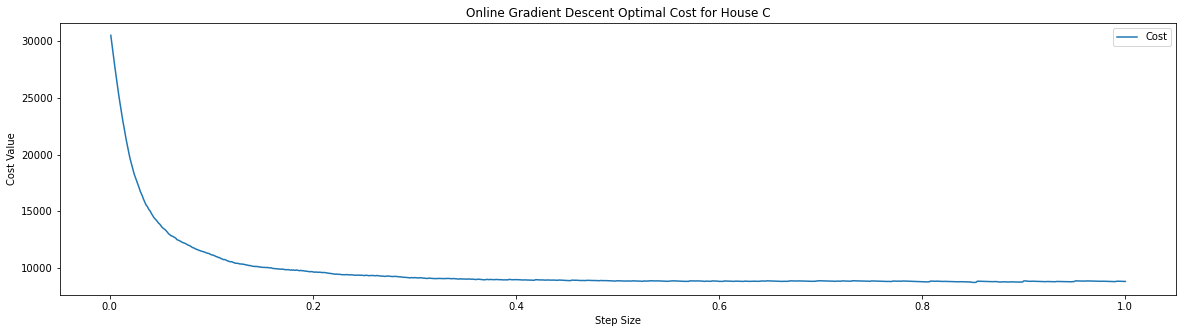

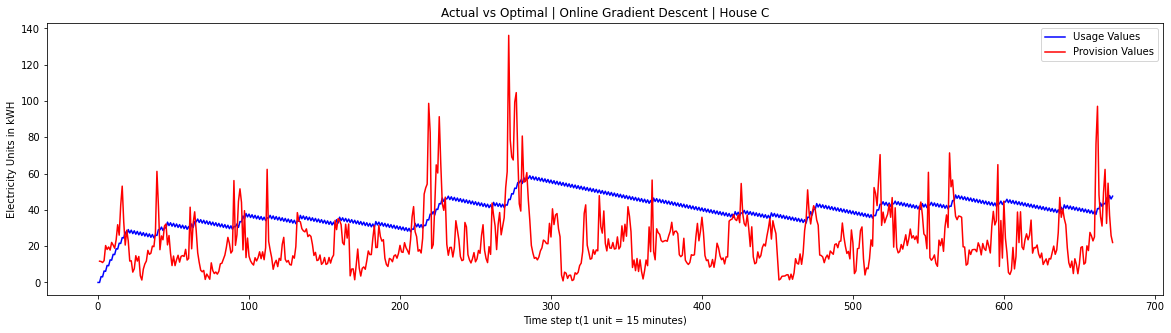

In [22]:
i = 1
costs = []
steps = []
step = 0
for k in range(1000):
    step += 0.001
    x = online_gradient_descent(energyData[i], steps = step)
    steps.append(step)
    costs.append(cost("Cost", x ,energyData[i], False))

x = online_gradient_descent(energyData[i], steps = steps[costs.index(min(costs))])
print("Optimal cost found at step: ", steps[costs.index(min(costs))])
opt = cost("Online Gradient Descent at Optimal cost", x, energyData[i], True)
opt_dict[i]['OGD'] = opt
decision_dict[i]['OGD'] = x
ogd.append(opt)
plot_ogd(houses[i], steps, costs)
plot_comparison(houses[i], x, energyData[i])


Optimal cost found at step:  0.9920000000000008

The objective value for Online Gradient Descent at Optimal cost is 22013.624520051995


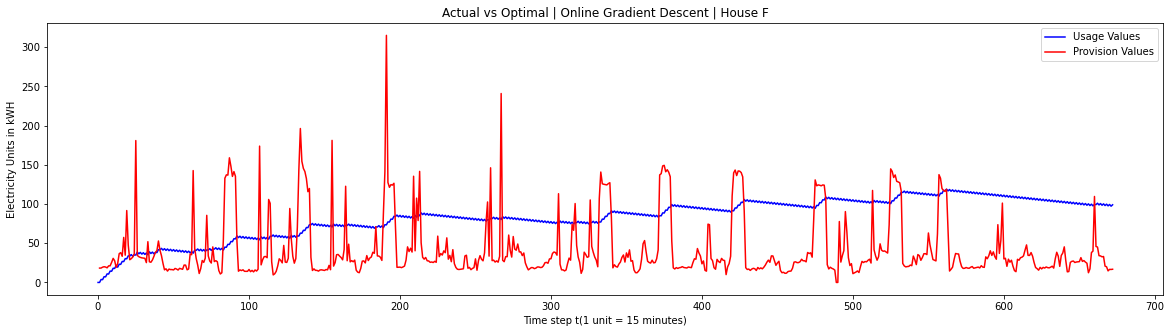

In [23]:
i = 2
costs = []
steps = []
step = 0
for k in range(1000):
    step += 0.001
    x = online_gradient_descent(energyData[i], steps = step)
    steps.append(step)
    costs.append(cost("Cost", x ,energyData[i], False))

x = online_gradient_descent(energyData[i], steps = steps[costs.index(min(costs))])
print("Optimal cost found at step: ", steps[costs.index(min(costs))])
opt = cost("Online Gradient Descent at Optimal cost", x, energyData[i], True)
opt_dict[i]['OGD'] = opt
decision_dict[i]['OGD'] = x
ogd.append(opt)
plot_comparison(houses[i], x, energyData[i])

# Receding Horizon Control 

In [24]:
def RHC(houseno, y, predictionHorizon, prediction_algo):
  T = 2*24*14
  p = 0.4/2
  a = 4/2
  b = 4/2
  optValues = np.zeros(T)
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    optValues[horizonStart] = x.value[0];

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])
  
  opt_dict[houseno]['RHC' + '_' + prediction_algo] = obj
  decision_dict[houseno]['RHC' + '_' + prediction_algo] = optValues
#   plot_comparison("B", optValues, y[:T]) #TODO
  return obj

In [25]:
def plot_RHC(title, windows, costs):
    fig = plt.figure(figsize=(15, 4))
    plt.title(title)
    plt.plot(windows, costs, label = "Prediction Window Value")
    plt.legend()
    plt.ylabel("Cost Value")
    plt.xlabel("Prediction Window Size")

In [37]:
y_extratrees = pd.read_csv("./data/prediction_B_lr.csv", usecols = ['prediction'])
y_svr = pd.read_csv("./data/prediction_B_rf.csv", usecols = ['prediction'])

y_C_lr = pd.read_csv("./data/pred_c_lr.csv").iloc[:, 1] 
y_C_rf = pd.read_csv("./data/pred_c_rf.csv").iloc[:, 1] 
y_f_lr = pd.read_csv("./data/f_pred_lr.csv").iloc[:, 0] 
y_f_rf = pd.read_csv("./data/f_pred_rf.csv").iloc[:, 0] 

predictions = [
    [y_extratrees['prediction'], y_svr['prediction']],
    [y_C_lr, y_C_rf],
    [y_f_lr, y_f_rf]]

Optimal cost for RHC and Linear Regression found at window size:  3

Optimal cost is:  320.96741974782117


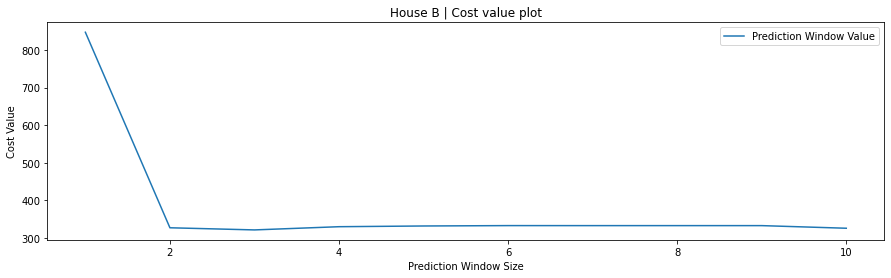

In [26]:

houseno = 0
predictData = predictions[houseno][0]
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(RHC(houseno, predictData.to_numpy(), i, 'LR'))

x = RHC(houseno, predictData.to_numpy(), windows[costs.index(min(costs))], 'LR')
print("Optimal cost for RHC and Linear Regression found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)
plot_RHC("House B | Cost value plot", windows, costs)

Optimal cost for RHC and Random Forest found at window size:  3

Optimal cost is:  239.01666653802405


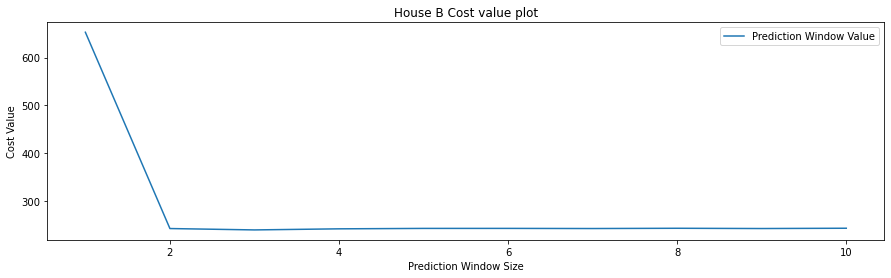

In [27]:

houseno = 0
predictData = predictions[houseno][1]
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(RHC(houseno, predictData.to_numpy(), i, 'RF'))

x = RHC(houseno, predictData.to_numpy(), windows[costs.index(min(costs))], 'RF')
print("Optimal cost for RHC and Random Forest found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)
plot_RHC("House B Cost value plot", windows, costs)

In [28]:

houseno = 1
predictData = predictions[houseno][0]
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(RHC(houseno, predictData.to_numpy(), i, 'LR'))
    
x = RHC(houseno, predictData.to_numpy(), windows[costs.index(min(costs))], 'LR')
print("Optimal cost for RHC and Linear Regression found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)
plot_RHC("House C Cost value plot", windows, costs)

KeyboardInterrupt: 

In [ ]:

houseno = 1
predictData = predictions[houseno][1]
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(RHC(houseno, predictData.to_numpy(), i, 'RF'))
    
x = RHC(houseno, predictData.to_numpy(), windows[costs.index(min(costs))], 'RF')
print("Optimal cost for RHC and Random Forest found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)
plot_RHC("House C Cost value plot", windows, costs)

In [ ]:

houseno = 2
predictData = predictions[houseno][0]
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(RHC(houseno, predictData.to_numpy(), i, 'LR'))
    
x = RHC(houseno, predictData.to_numpy(), windows[costs.index(min(costs))], 'LR')
print("Optimal cost for RHC and Linear Regression found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)
plot_RHC("House F Cost value plot", windows, costs)

In [ ]:

houseno = 2
predictData = predictions[houseno][1]
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(RHC(houseno, predictData.to_numpy(), i, 'RF'))
    
x = RHC(houseno, predictData.to_numpy(), windows[costs.index(min(costs))], 'RF')
print("Optimal cost for RHC and Random Forest Regression found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)
plot_RHC("House F Cost value plot", windows, costs)

## Commitment Horizon Control


In [ ]:
def CHC(houseno, y, predictionHorizon, commitmentHorizon, prediction_algo):
  T = 2*24*14;
  p = 0.4/2;
  a = 4/2;
  b = 4/2;
  optValues = np.zeros(T + 20);
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    for i in range(0, commitmentHorizon):
      optValues[horizonStart + i] += x.value[i];

  optValues = optValues/commitmentHorizon

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])

  opt_dict[houseno]['CHC' + '_' + prediction_algo] = obj
  decision_dict[houseno]['CHC' + '_' + prediction_algo] = optValues

  return obj

In [ ]:
def plot_CHC(title,windows, costs):
    fig = plt.figure(figsize=(15, 4))
    plt.title(title)
    plt.plot(windows, costs, label = "Commitment Horizon Value")
    plt.legend()
    plt.ylabel("Cost Value")
    plt.xlabel("Commitment Horizon Size")

#### House B 

In [ ]:
# CHC(houseno, y_extratrees['prediction'].to_numpy(), 10, windows[costs.index(min(costs))], "LR")

In [ ]:
def runCHC(houseno, predData, predictionHorizon, label):
    costs = []
    windows = []
    for i in range(2,11):
        windows.append(i)
        costs.append(CHC(houseno, predData.to_numpy(), predictionHorizon, i, label))
    x = CHC(houseno, predData.to_numpy(), predictionHorizon, windows[costs.index(min(costs))], label)
    print("Optimal cost for CHC found for House ", houses[houseno],  "at commitment horizon size ", windows[costs.index(min(costs))])
    print("\nOptimal cost is: ", x)
    plot_CHC("Commitment Horizon Values for CHC and "+label + "| House " + houses[houseno], windows,costs)

In [ ]:

runCHC(0, y_extratrees['prediction'], 10, "LR" )

runCHC(0, y_svr['prediction'], 10, "RF" )

#### House C

In [ ]:

runCHC(1, y_C_lr, 10, "LR" )

runCHC(1, y_C_rf, 10, "RF" )

#### House F 

In [ ]:

runCHC(2, y_f_lr, 10, "LR" )

runCHC(2, y_f_rf, 10, "RF" )

# Comparisons with Static Offline and Dynamic Offline Algorithms

In [ ]:
houseno = 0
sns.set_style("white")
fig = plt.figure(figsize=(24, 8))
opts = opt_dict[houseno]
x=list(opts.keys())
ax = sns.pointplot(x=list(opts.keys()), y=[score for score in opts.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(opts.values()):
    ax.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Cost for objective function', size=20, labelpad=12.5)
plt.xlabel('Algorithm', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Optimal Cost of Algorithms | House B', size=20)

plt.show()

In [ ]:
houseno = 1
sns.set_style("white")
fig = plt.figure(figsize=(20, 6))
opts = opt_dict[houseno]
x=list(opts.keys())
ax = sns.pointplot(x=list(opts.keys()), y=[score for score in opts.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(opts.values()):
    ax.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Cost for objective function', size=20, labelpad=12.5)
plt.xlabel('Algorithm', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Optimal Cost of Algorithms| House C', size=20)

plt.show()

In [ ]:
houseno = 2
sns.set_style("white")
fig = plt.figure(figsize=(20, 6))
opts = opt_dict[houseno]
x=list(opts.keys())
ax = sns.pointplot(x=list(opts.keys()), y=[score for score in opts.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(opts.values()):
    ax.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Cost for objective function', size=20, labelpad=12.5)
plt.xlabel('Algorithm', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Optimal Cost of Algorithms | House F', size=20)

plt.show()

In [ ]:
# house = ['B','C','F']
# ogd_cost = [241.398313, 9827.927567, 23715.980733]
# rhc_cost = [220.439009, 8497.530250, 21493.746005298344]
# chc_cost = [193.563905, 8463.635047, 18563.935598]

# comparison = pd.DataFrame({
#     'House': house,
#     'Offline static': os_cost,
#     'Offline Dynamic': od_cost,
#     'Online Gradient Descent': ogd_cost,
#     'Receding Horizon Control' : rhc_cost,
#     'Commitment Horizon Control' : chc_cost,
# })

# print("Comparison - Costs for House B, C, F")
# display(comparison)

Hence its observed that 

### Varying a and b for the best combination of control algorithm and prediction algorithm

In [ ]:
def chc_vary_and_b(y, predictionHorizon, commitmentHorizon, prediction_algo, a, b):
  T = 2*24*14;
  p = 0.4/2;
  a = a/2;
  b = b/2;
  optValues = np.zeros(T + 20);
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    for i in range(0, commitmentHorizon):
      optValues[horizonStart + i] += x.value[i];

  optValues = optValues/commitmentHorizon

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])

  return obj

In [ ]:
costs = []
windows = []
b = 4
for i in range(1,11):
    windows.append(i)
    costs.append(chc_vary_and_b(y_svr['prediction'].to_numpy(), 10, 3, 'RF', i, b))

fig = plt.figure(figsize=(20, 5))
plt.title("Impact of changing a for CHC and SVR with b=4 and commitment horizon=10")
plt.plot(windows, costs, label = "a")
plt.legend()
plt.ylabel("Cost Value")
plt.xlabel("a")

In [ ]:
costs = []
windows = []
a = 4
for i in range(1,11):
    windows.append(i)
    costs.append(chc_vary_and_b(y_svr['prediction'].to_numpy(), 10, 3, 'RF', a, i))
    
fig = plt.figure(figsize=(24, 8))
plt.title("Impact of changing b for CHC and SVR with a=4 and commitment horizon=10")
plt.plot(windows, costs, label = "a")
plt.legend()
plt.ylabel("Cost Value")
plt.xlabel("b")

# Algorithm Selection

In [ ]:
def online_gradient_descent_fixed_window(y, steps):
    n = 4
    x = [0.0] * (n + 1)
    x[1] = 0
    p = 0.4/2
    a = 4/2
    b = 4/2
    for t in range(1, n):
      if (y[t] > x[t]):
          if (x[t] > x[t - 1]):
              slope = p - a + b;
          else:
              slope = p - a - b;
      else:
          if (x[t] > x[t - 1]):
              slope = p + b;
          else:
              slope = p - b;
      x[t + 1] = x[t] - steps * slope
    return x

def rhc_fixed_window(y, predictionHorizon, prediction_algo):
  T = 4;
  p = 0.4/2;
  a = 4/2;
  b = 4/2;
  optValues = np.zeros(T);
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    optValues[horizonStart] = x.value[0];

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])

  return obj

def chc_fixed_window(y, predictionHorizon, commitmentHorizon, prediction_algo):
  T = 4;
  p = 0.4/2;
  a = 4/2;
  b = 4/2;
  optValues = np.zeros(T + 20);
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    for i in range(0, commitmentHorizon):
      optValues[horizonStart + i] += x.value[i];

  optValues = optValues/commitmentHorizon

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])

  return obj

def cost_fixed_window(x, y):
    cost = 0
    p = 0.4/2
    a = 4/2
    b = 4/2
    for i in range(1, 5):
        cost += p * x[i] + a * max(0, y[i] - x[i] + b * abs(x[i] - x[i - 1]))
   
    return cost

def offline_dynamic_provision_fixed_window(y):
  p = 0.4/2
  a = 4/2
  b = 4/2
  x = cp.Variable(4)
  cost = 0

  for i in range(1,4):
      cost += p*x[i] + a*cp.maximum(0, y[i-1] - x[i]) + b*cp.abs(x[i]-x[i-1])
  
  objective = cp.Minimize(cost)
  constraints = [x[0] == 0, x[1:] >= 0]
  problem = cp.Problem(objective, constraints)
  result = problem.solve()
  opt = np.array(x.value)
  opt = np.insert(opt, 0, 0., axis=0)
  
  return opt

# Deterministic Approach

The algorithm followed in the Deterministic approach is as follows:


1. Choose a fixed window size. Ex. w = 4 and different time slots t1 & t2 at step size 4
2. Now, we need to iterate over the time horizon (T=672) with step size = window size
3. In each window, evaluate the objective function value for each algorithm
4. The algorithm which gives the value closest as compared to the offline algorithm wins that round or window size
5. We then measured the number of times OGD, RHC and CHC won respectively
6. In the end, The algorithm which won the maximum number of times is the winner


In [ ]:
import operator

def deterministicApproach():
  win_ogd = 0;
  win_rhc = 0;
  win_chc = 0;
  obj_diff_dict = {}
  y = y_svr['prediction'].to_numpy()
  for i in range(1, 673):
    obj_ogd = cost_fixed_window(online_gradient_descent_fixed_window(y, 0.017), y[i:])
    obj_rhc = rhc_fixed_window(y[i:], 3, 'SVR')
    obj_chc = chc_fixed_window(y[i:], 10, 9, 'SVR')
    obj_offline_dynamic = cost_fixed_window(offline_dynamic_provision_fixed_window(y[i:]), y[i:])
    obj_diff_dict['OGD'] = abs(obj_offline_dynamic - obj_ogd)
    obj_diff_dict['RHC'] = abs(obj_offline_dynamic - obj_rhc)
    obj_diff_dict['CHC'] = abs(obj_offline_dynamic - obj_chc)
    optimal_algo = min(obj_diff_dict.items(), key=operator.itemgetter(1))[0]
    
    if optimal_algo == 'OGD':
      win_ogd += 1
    elif optimal_algo == 'RHC':
      win_rhc += 1
    else:
      win_chc += 1

  obj_win_dict = {}
  obj_win_dict['OGD'] = win_ogd
  obj_win_dict['RHC'] = win_rhc
  obj_win_dict['CHC'] = win_chc
  print(obj_win_dict)
  return max(obj_win_dict.items(), key=operator.itemgetter(1))[0]



In [ ]:
print('The winner for deterministic approach is: ',deterministicApproach())

# Randomized Algorithm


In [ ]:
import math

def randomizeAlgo():
  wt_ogd = 1/3;
  wt_rhc = 1/3;
  wt_chc = 1/3;
  obj_diff_dict = {}
  y = y_svr['prediction'].to_numpy()

  for i in range(1, 673):
    obj_ogd = cost_fixed_window(online_gradient_descent_fixed_window(y, 0.017), y[i:])
    obj_rhc = rhc_fixed_window(y[i:], 3, 'SVR')
    obj_chc = chc_fixed_window(y[i:], 10, 9, 'SVR')
    obj_offline_dynamic = cost_fixed_window(offline_dynamic_provision_fixed_window(y[i:]), y[i:])
    obj_diff_dict['OGD'] = abs(obj_offline_dynamic - obj_ogd)
    obj_diff_dict['RHC'] = abs(obj_offline_dynamic - obj_rhc)
    obj_diff_dict['CHC'] = abs(obj_offline_dynamic - obj_chc)
    most_optimal_algo = min(obj_diff_dict.items(), key=operator.itemgetter(1))[0]
    least_optimal_algo = max(obj_diff_dict.items(), key=operator.itemgetter(1))[0]
    
    
    if i > 1:
      if most_optimal_algo == 'OGD':
        wt_ogd += 0.0005
      elif most_optimal_algo == 'RHC':
        wt_rhc += 0.0005
      else:
        wt_chc += 0.0005

      if least_optimal_algo == 'OGD':
        wt_ogd -= 0.0005
      elif least_optimal_algo == 'RHC':
        wt_rhc -= 0.0005
      else:
        wt_chc -= 0.0005

    last_winner = most_optimal_algo
    last_loser = least_optimal_algo

  obj_wt_dict = {}
  obj_wt_dict['OGD'] = wt_ogd
  obj_wt_dict['RHC'] = wt_rhc
  obj_wt_dict['CHC'] = wt_chc
  print('The final weights for randomized approach is: ', obj_wt_dict)

In [ ]:
randomizeAlgo()

In [ ]:
def algorithmsCompare():
  y = y_svr['prediction'].to_numpy()
  obj_deterministic = 0
  obj_offline_dynamic = 0
  obj_randomized = 0

  for i in range(1, 673):
    obj_deterministic += chc_fixed_window(y[i:], 10, 9, 'SVR')
    obj_offline_dynamic += cost_fixed_window(offline_dynamic_provision_fixed_window(y[i:]), y[i:])
    obj_randomized += 0.54*chc_fixed_window(y[i:], 10, 9, 'SVR')+0.05*rhc_fixed_window(y[i:], 3, 'SVR')+0.41*cost_fixed_window(online_gradient_descent_fixed_window(y, 0.017), y[i:])

  obj_dict = {}
  obj_dict['Deterministic'] = obj_deterministic
  obj_dict['Offline Dynamic'] = obj_offline_dynamic
  obj_dict['Randomized'] = obj_randomized
  print(obj_dict)
  return max(obj_dict.items(), key=operator.itemgetter(1))[0]

In [ ]:
algorithmsCompare()